Advantage Actor-Critic(A2C) 알고리즘은 강화 학습에서 정책(Actor)과 가치 함수(Critic)를 동시에 학습하는 방법

/Users/jangyoung/Documents/venv/stts/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1, Reward: 20.0
Episode 2, Reward: 26.0
Episode 3, Reward: 26.0
Episode 4, Reward: 22.0
Episode 5, Reward: 34.0
Episode 6, Reward: 24.0
Episode 7, Reward: 55.0
Episode 8, Reward: 24.0
Episode 9, Reward: 21.0
Episode 10, Reward: 36.0
Episode 11, Reward: 26.0
Episode 12, Reward: 17.0
Episode 13, Reward: 44.0
Episode 14, Reward: 54.0
Episode 15, Reward: 76.0
Episode 16, Reward: 45.0
Episode 17, Reward: 72.0
Episode 18, Reward: 38.0
Episode 19, Reward: 45.0
Episode 20, Reward: 26.0
Episode 21, Reward: 42.0
Episode 22, Reward: 55.0
Episode 23, Reward: 28.0
Episode 24, Reward: 51.0
Episode 25, Reward: 19.0
Episode 26, Reward: 29.0
Episode 27, Reward: 29.0
Episode 28, Reward: 19.0
Episode 29, Reward: 32.0
Episode 30, Reward: 21.0
Episode 31, Reward: 26.0
Episode 32, Reward: 15.0
Episode 33, Reward: 18.0
Episode 34, Reward: 21.0
Episode 35, Reward: 15.0
Episode 36, Reward: 25.0
Episode 37, Reward: 18.0
Episode 38, Reward: 19.0
Episode 39, Reward: 12.0
Episode 40, Reward: 16.0
Episode 4

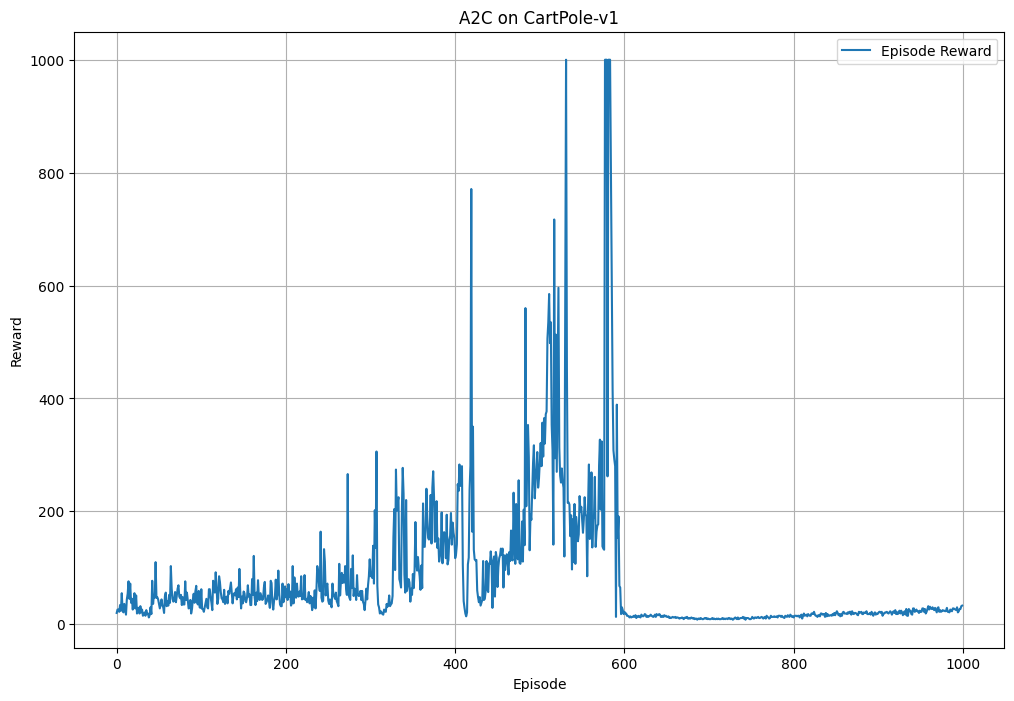

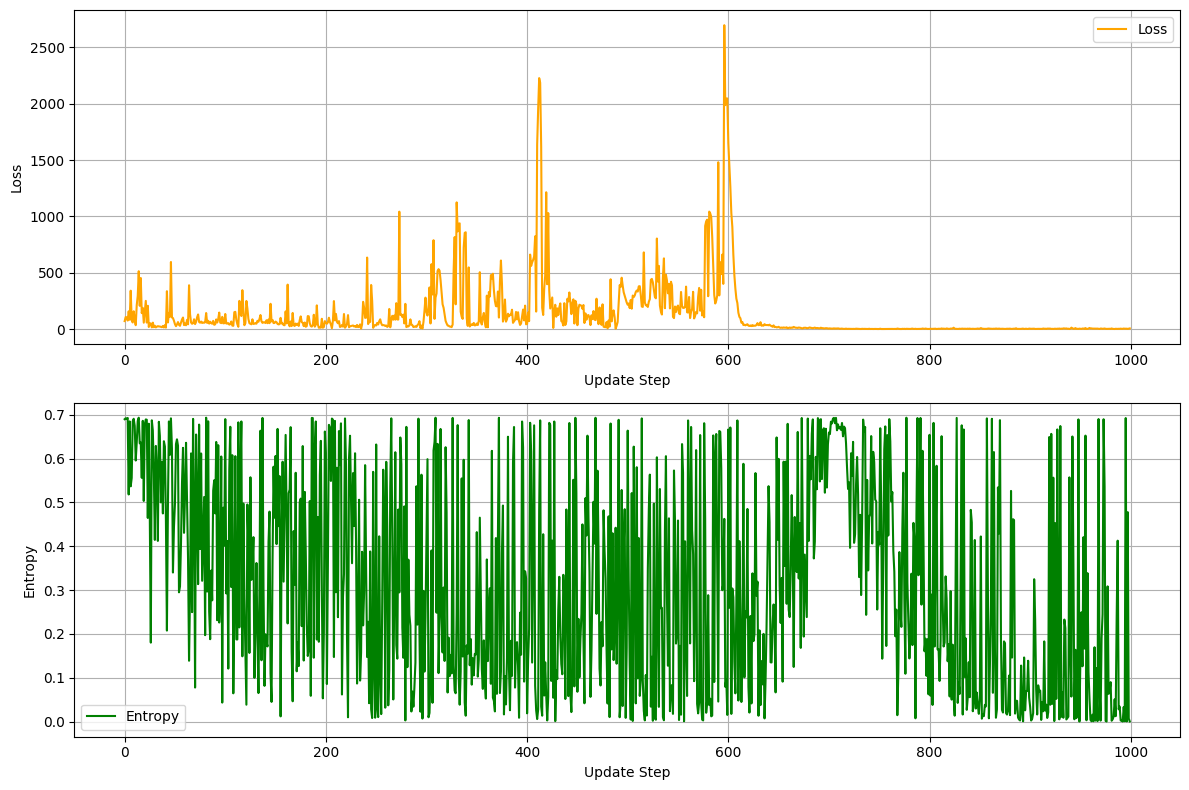

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 하이퍼파라미터 설정
GAMMA = 0.99
LR = 0.01
ENTROPY_BETA = 0.05
UPDATE_INTERVAL = 5
NUM_EPISODES = 1000
MODEL_PATH = 'a2c_cartpole.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# "mps"
# torch.backends.mps().is_abailable()

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc = nn.Linear(state_dim, 128)
        self.actor = nn.Linear(128, action_dim) # action space n
        self.critic = nn.Linear(128, 1) # state
    
    def forward(self, x):
        x = F.relu(self.fc(x))
        # state -> 128 hidden state
        policy = F.softmax(self.actor(x), dim=-1) # <
        value = self.critic(x) # <
        return policy, value

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(state_dim, action_dim).to(device) # model(x)
optimizer = optim.Adam(model.parameters(), lr=LR) # scheduler 

losses = []
entropies = []
episode_rewards = []

def td_target(rewards):
    R_to_Go = 0
    discnt_rewards = []
    rewards.reverse()
    for r in rewards:
        R_to_Go = r + GAMMA * R_to_Go # bellman () -> V(s)
        discnt_rewards.append(R_to_Go)
    discnt_rewards.reverse()
    return discnt_rewards

def train():
    state, _ = env.reset() # 초기화 
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    log_probs, values, rewards, dones = [], [], [], []
    total_reward = 0

    for _ in range(1000):  # Max steps per episode
        policy, value = model(state)
        
        dist = torch.distributions.Categorical(policy)
        action = dist.sample().item()
        
        next_state, reward, done, _, _ = env.step(action)
        

        log_probs.append(dist.log_prob(torch.tensor(action, device=device)))
        values.append(value)
        rewards.append(reward)
        dones.append(done)
        total_reward += reward
        
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        
        if done:
            break

    
    discnt_rewards = td_target(rewards)
    discnt_rewards = torch.tensor(discnt_rewards, dtype=torch.float32, device=device)
    values = torch.cat(values).squeeze(1)
    advantage = discnt_rewards - values.detach()

    log_probs = torch.stack(log_probs)
    actor_loss = -(log_probs * advantage).mean()
    critic_loss = .5 * F.mse_loss(values, discnt_rewards)
    
    entropy = torch.stack([torch.distributions.Categorical(probs).entropy() 
                          for probs in policy]).mean()
    
    loss = actor_loss + critic_loss - ENTROPY_BETA * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    entropies.append(entropy.item())

    return total_reward

best = 0
for episode in range(NUM_EPISODES):
    reward = train()
    episode_rewards.append(reward)
    print(f"Episode {episode + 1}, Reward: {reward}")

    # if (episode + 1) % 100 == 0:
    if reward > best:
        torch.save(model.state_dict(), MODEL_PATH)
        best = reward

env.close()

# 시각화 코드 (동일)
plt.figure(figsize=(12, 8))
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('A2C on CartPole-v1')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(losses, label='Loss', color='orange')
plt.xlabel('Update Step')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(entropies, label='Entropy', color='green')
plt.xlabel('Update Step')
plt.ylabel('Entropy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
import gym
env = gym.make("CartPole-v1", render_mode="human")
# 저장된 모델 불러오기
# 모델 초기화
model = ActorCritic(state_dim, action_dim).to(device)

# 저장된 가중치 불러오기
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# 모델을 평가 모드로 전환
model.eval()

# 불러온 모델로 테스트
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
total_reward = 0

while True:
    
    env.render()
    with torch.no_grad():
        policy, _ = model(state)
        action = torch.argmax(policy).item()
    next_state, reward, done, _, _ = env.step(action)

    total_reward += reward
    state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
    if done:
        break

print(f"Total Reward in Test: {total_reward}")
env.close()

2025-02-20 14:44:50.535 Python[59725:6831676] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-20 14:44:50.535 Python[59725:6831676] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/Users/jangyoung/Documents/venv/stts/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total Reward in Test: 349.0


: 

SAC는 엔트로피 보상을 활용하여 안정적인 탐색을 수행하며, 이중 Q 네트워크를 사용하여 학습 안정성을 높인 강화학습 알고리즘, 연속적인 행동 공간에서 주로 사용됩니다. 그러나 CartPole과 같은 이산적 행동 공간을 가진 환경에서도 SAC를 적용할 수 있습니다